In [1]:
# Importing libs
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from jinja2 import Template
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from IPython.display import display, Markdown

In [2]:
# Open dataset

data = pd.read_csv('../estaticos_market.csv', index_col=0)

In [3]:
# Removing rows where 'de_ramo' == 'OUTROS' to get some full-filled columns for testing

data = data.loc[data['de_ramo'] != 'OUTROS']

data.shape

(460371, 181)

In [4]:
# Removing columns where exists NaNs

removed_columns = []
for col in data.iloc[:, 1:]:
    if data[col].isna().sum() != 0:
        removed_columns.append(col)

new_columns = list(set(data.columns) - set(removed_columns))
data = data.loc[:, new_columns]

data.shape

(460371, 28)

In [5]:
data.columns

Index(['fl_veiculo', 'fl_email', 'fl_simples_irregular', 'fl_telefone',
       'fl_passivel_iss', 'de_ramo', 'idade_emp_cat', 'fl_ltda', 'fl_antt',
       'fl_rm', 'sg_uf', 'setor', 'id', 'fl_me', 'natureza_juridica_macro',
       'vl_total_veiculos_pesados_grupo', 'nm_divisao', 'fl_epp',
       'vl_total_veiculos_leves_grupo', 'de_natureza_juridica', 'fl_mei',
       'qt_filiais', 'fl_st_especial', 'idade_empresa_anos', 'nm_segmento',
       'fl_spa', 'fl_sa', 'fl_matriz'],
      dtype='object')

In [6]:
with open('dict.json') as f:
    vars_dict = json.load(f)

for col in data:
    if col == 'id':
        continue
    print(f'{col} -> {vars_dict[col]}')

fl_veiculo -> boolean, true if the company owns at least one vehicle
fl_email -> boolean value, true if the cnpj has an email registered at the IRF database.
fl_simples_irregular -> boolean, true if the company is taxed under the SIMPLES regime and has a impeditive CNAE (economic activities that are not allowed to be taxed according to the simples regime) revenue above the limit of the regime.
fl_telefone -> boolean value, true if the company has a phone number registered in IRS database.
fl_passivel_iss -> boolean, true if the company performs any activity that is taxable under ISS - Tax under services.
de_ramo -> description of a macro activity category/branch based on the CNAE code.
idade_emp_cat -> character, age of the company by ranges
fl_ltda -> boolean value, true if the company has the term 'LTDA' in the end of its legal name.
fl_antt -> boolean, true if the company is certified by ANTT for trasnportation purposes
fl_rm -> character, true if the company address is located in a

In [7]:
# Removing features by its description
cols_to_remove = [
    'fl_telefone', # Se tem número de telefone registrado no db. Acho que da de tirar
    'fl_epp', # Isso não varia em nenhuma linha
]

data = data.loc[:, set(data.columns) - set(cols_to_remove)]

data.shape

(460371, 26)

In [8]:
# Make the index as the 'id' columns

data.set_index('id', inplace=True)

data.shape

(460371, 25)

In [9]:
data.dtypes

fl_veiculo                          object
vl_total_veiculos_leves_grupo      float64
fl_email                              bool
fl_simples_irregular                object
fl_passivel_iss                     object
de_ramo                             object
idade_emp_cat                       object
de_natureza_juridica                object
fl_ltda                               bool
fl_antt                             object
fl_mei                                bool
fl_rm                               object
sg_uf                               object
setor                               object
qt_filiais                           int64
fl_st_especial                        bool
fl_me                                 bool
natureza_juridica_macro             object
idade_empresa_anos                 float64
nm_segmento                         object
vl_total_veiculos_pesados_grupo    float64
fl_spa                              object
nm_divisao                          object
fl_sa      

In [10]:
# Fix True/False objects
data['fl_passivel_iss'] = data['fl_passivel_iss'].astype('bool')
data['fl_antt'] = data['fl_antt'].astype('bool')
data['fl_spa'] = data['fl_spa'].astype('bool')
data['fl_simples_irregular'] = data['fl_simples_irregular'].astype('bool')
data['fl_veiculo'] = data['fl_veiculo'].astype('bool')


data.dtypes

fl_veiculo                            bool
vl_total_veiculos_leves_grupo      float64
fl_email                              bool
fl_simples_irregular                  bool
fl_passivel_iss                       bool
de_ramo                             object
idade_emp_cat                       object
de_natureza_juridica                object
fl_ltda                               bool
fl_antt                               bool
fl_mei                                bool
fl_rm                               object
sg_uf                               object
setor                               object
qt_filiais                           int64
fl_st_especial                        bool
fl_me                                 bool
natureza_juridica_macro             object
idade_empresa_anos                 float64
nm_segmento                         object
vl_total_veiculos_pesados_grupo    float64
fl_spa                                bool
nm_divisao                          object
fl_sa      

In [11]:
# Generating dummies for the categorical features, one hot encoding

new_dfs = []
to_remove_cols = []
for col in data:
    if data[col].dtype == np.object:
        to_remove_cols.append(col)
        dummies = pd.get_dummies(data[col], prefix=col)
        new_dfs.append(dummies)
    
    elif data[col].dtype == np.bool:
        to_remove_cols.append(col)
        d = data[col].astype(np.int64)
        new_dfs.append(d)

data = data.loc[:, list(set(data.columns) - set(to_remove_cols))]
        
for d in new_dfs:
    data = data.join(d)

data.columns

Index(['qt_filiais', 'idade_empresa_anos', 'vl_total_veiculos_leves_grupo',
       'vl_total_veiculos_pesados_grupo', 'fl_veiculo', 'fl_email',
       'fl_simples_irregular', 'fl_passivel_iss',
       'de_ramo_ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL',
       'de_ramo_ATIVIDADES IMOBILIARIAS',
       ...
       'nm_divisao_SERVICOS DE ESCRITORIO DE APOIO ADMINISTRATIVO E OUTROS SERVICOS PRESTADOS PRINCIPALMENTE AS EMPRESAS',
       'nm_divisao_SERVICOS DOMESTICOS',
       'nm_divisao_SERVICOS ESPECIALIZADOS PARA CONSTRUCAO',
       'nm_divisao_SERVICOS PARA EDIFICIOS E ATIVIDADES PAISAGISTICAS',
       'nm_divisao_TELECOMUNICACOES', 'nm_divisao_TRANSPORTE AEREO',
       'nm_divisao_TRANSPORTE AQUAVIARIO', 'nm_divisao_TRANSPORTE TERRESTRE',
       'fl_sa', 'fl_matriz'],
      dtype='object', length=248)

In [12]:
data.shape

(460371, 248)

## Métrica

Usar a média do score das empresas do portifólio tiradas como teste

In [13]:
def metric_score(test_indexes, score):
    return score.loc[test_indexes].mean()

### Testando portifólio 1

In [14]:
# Load clients of portifolio1

portfilio1 = pd.read_csv('../estaticos_portfolio1.csv', index_col=0)

info_columns = ['tech', 'general_score', 'test_score', 'std', 'min_score', 'max_score']
info = []

#### Usando vetor com média aritmética das features 

Para definir o perfil do portifólio e medir a similaridade entre esse vetor e todos

In [15]:
clients_p1_data = data.loc[portfilio1['id']]

train, test = train_test_split(clients_p1_data, test_size=0.2)

data_no_train = data.loc[set(data.index) - set(train.index)]

# Making the user profile
u = dict()
for col in train:
    u[col] = clients_p1_data[col].mean()

user = pd.DataFrame([u])

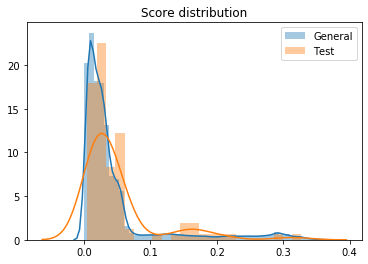

In [16]:
similarities = pd.DataFrame(data=cosine_similarity(data_no_train, user), columns=['score'])
similarities.index = data_no_train.index

sns.distplot(similarities, label='General').set_title('Score distribution')
sns.distplot(similarities.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()


In [17]:
print(f'Média score geral: {similarities.mean()}')
print(f'Média score dos testes: {similarities.loc[test.index].mean()}')

info.append([
    'Média da similaridade e vetor usuário',
    similarities.mean()[0],
    similarities.loc[test.index].mean()[0],
    similarities.std()[0],
    similarities.min()[0],
    similarities.max()[0]
])

Média score geral: score    0.04666
dtype: float64
Média score dos testes: score    0.049081
dtype: float64


#### Usando a similaridade entre todos e média

Usando média das similaridades entre uma empresa e as do treino para definir os scores

In [18]:
# Tira os dados que serão usados como treino, ou seja, empresas para comparar as demais que já estão no portifólio
data_no_train = data.loc[set(data.index) - set(train.index)]

# Calcula similaridade entre os dados e o treino
sim = cosine_similarity(data_no_train, train)

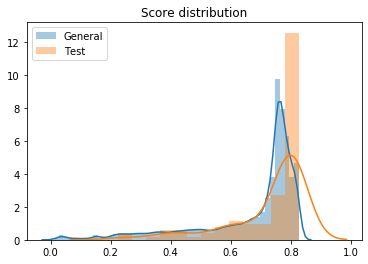

In [19]:
indexes = data_no_train.index
columns = train.index

similarities = pd.DataFrame(sim)
similarities.columns = columns
similarities.index = indexes
score = similarities.mean(axis=1)

sns.distplot(score, label='General').set_title('Score distribution')
sns.distplot(score.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()

In [20]:
# Score de cada empresa teste é média da similaridade dela com as de treino
# e o score da métrica é média do score dos testes
print(f'Média score geral: {score.mean()}')
print(f'Média score dos testes: {score.loc[test.index].mean()}')

info.append([
    'Média da similaridade com todas',
    score.mean(),
    score.loc[test.index].mean(),
    score.std(),
    score.min(),
    score.max()
])

Média score geral: 0.6713270777113077
Média score dos testes: 0.7283859046565324


#### Usando a similaridade entre todos e maior

Usando a maior das similaridades entre uma empresa e as do treino para definir os scores

In [21]:
# Tira os dados que serão usados como treino, ou seja, empresas para comparar as demais que já estão no portifólio
data_no_train = data.loc[set(data.index) - set(train.index)]

# Calcula similaridade entre os dados e o treino
sim = cosine_similarity(data_no_train, train)

In [22]:
data.shape[0] == sum(sim.shape)

True

In [23]:
indexes = data_no_train.index
columns = train.index

similarities = pd.DataFrame(np.amax(sim, axis=1))
similarities.index = indexes

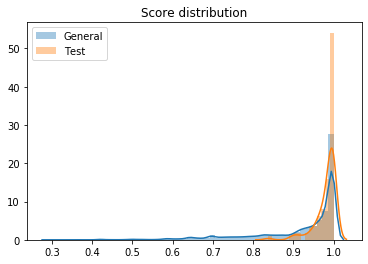

In [24]:
sns.distplot(similarities, label='General').set_title('Score distribution')
sns.distplot(similarities.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()

In [25]:
# Score de cada empresa teste é maior similaridade dela com as de treino
# e o score da métrica é média do score dos testes
print(f'Média score geral: {similarities.mean()}')
print(f'Média score dos testes: {similarities.loc[test.index].mean()}')


info.append([
    'Maior similaridade entre todas',
    similarities.mean()[0],
    similarities.loc[test.index].mean()[0],
    similarities.std()[0],
    similarities.min()[0],
    similarities.max()[0]
])

Média score geral: 0    0.920455
dtype: float64
Média score dos testes: 0    0.981294
dtype: float64


#### Recomendações aleatórias

Adicionar um valor aleatório entre 0 e 1 como score para cada empresa

Média score geral: 0    0.500175
dtype: float64
Média score dos testes: 0    0.477776
dtype: float64


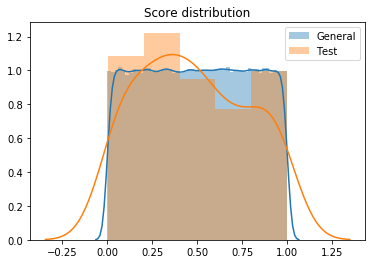

In [26]:
np.random.seed(42)

score = pd.DataFrame(data=np.random.rand(data_no_train.shape[0]))
score.index = data_no_train.index

print(f'Média score geral: {score.mean()}')
print(f'Média score dos testes: {score.loc[test.index].mean()}')

sns.distplot(score, label='General').set_title('Score distribution')
sns.distplot(score.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()

info.append([
    'Aleatório',
    score.mean()[0],
    score.loc[test.index].mean()[0],
    score.std()[0],
    score.min()[0],
    score.max()[0]
])

In [27]:
p1_info = pd.DataFrame(info, columns=info_columns)

p1_info

,tech,general_score,test_score,std,min_score,max_score
0,Média da similaridade e vetor usuário,0.046660,0.049081,0.067829,3.047972e-07,0.377314
1,Média da similaridade com todas,0.671327,0.728386,0.172563,9.812395e-03,0.828532
2,Maior similaridade entre todas,0.920455,0.981294,0.108975,2.995365e-01,1.000000
3,Aleatório,0.500175,0.477776,0.288539,2.227296e-06,0.999995


In [28]:
# Load clients of portifolio2

portfilio1 = pd.read_csv('../estaticos_portfolio2.csv', index_col=0)

info_columns = ['tech', 'general_score', 'test_score', 'std', 'min_score', 'max_score']
info = []

#### Usando vetor com média aritmética das features 

Para definir o perfil do portifólio e medir a similaridade entre esse vetor e todos

In [29]:
clients_p1_data = data.loc[portfilio1['id']]

train, test = train_test_split(clients_p1_data, test_size=0.2)

data_no_train = data.loc[set(data.index) - set(train.index)]

# Making the user profile
u = dict()
for col in train:
    u[col] = clients_p1_data[col].mean()

user = pd.DataFrame([u])

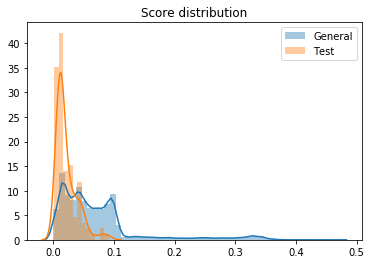

In [30]:
similarities = pd.DataFrame(data=cosine_similarity(data_no_train, user), columns=['score'])
similarities.index = data_no_train.index

sns.distplot(similarities, label='General').set_title('Score distribution')
sns.distplot(similarities.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()


In [31]:
print(f'Média score geral: {similarities.mean()}')
print(f'Média score dos testes: {similarities.loc[test.index].mean()}')

info.append([
    'Média da similaridade e vetor usuário',
    similarities.mean()[0],
    similarities.loc[test.index].mean()[0],
    similarities.std()[0],
    similarities.min()[0],
    similarities.max()[0]
])

Média score geral: score    0.071805
dtype: float64
Média score dos testes: score    0.02172
dtype: float64


#### Usando a similaridade entre todos e média

Usando média das similaridades entre uma empresa e as do treino para definir os scores

In [32]:
# Tira os dados que serão usados como treino, ou seja, empresas para comparar as demais que já estão no portifólio
data_no_train = data.loc[set(data.index) - set(train.index)]

# Calcula similaridade entre os dados e o treino
sim = cosine_similarity(data_no_train, train)

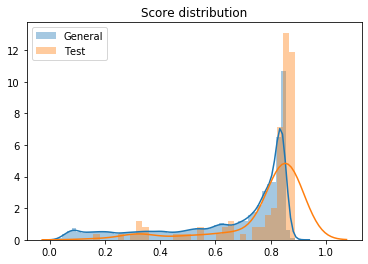

In [33]:
indexes = data_no_train.index
columns = train.index

similarities = pd.DataFrame(sim)
similarities.columns = columns
similarities.index = indexes
score = similarities.mean(axis=1)

sns.distplot(score, label='General').set_title('Score distribution')
sns.distplot(score.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()

In [34]:
# Score de cada empresa teste é média da similaridade dela com as de treino
# e o score da métrica é média do score dos testes
print(f'Média score geral: {score.mean()}')
print(f'Média score dos testes: {score.loc[test.index].mean()}')

info.append([
    'Média da similaridade com todas',
    score.mean(),
    score.loc[test.index].mean(),
    score.std(),
    score.min(),
    score.max()
])

Média score geral: 0.6497393181930045
Média score dos testes: 0.7834221275353892


#### Usando a similaridade entre todos e maior

Usando a maior das similaridades entre uma empresa e as do treino para definir os scores

In [35]:
# Tira os dados que serão usados como treino, ou seja, empresas para comparar as demais que já estão no portifólio
data_no_train = data.loc[set(data.index) - set(train.index)]

# Calcula similaridade entre os dados e o treino
sim = cosine_similarity(data_no_train, train)

In [36]:
data.shape[0] == sum(sim.shape)

True

In [37]:
indexes = data_no_train.index
columns = train.index

similarities = pd.DataFrame(np.amax(sim, axis=1))
similarities.index = indexes

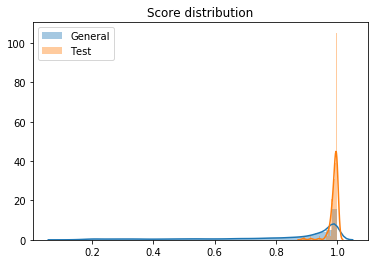

In [38]:
sns.distplot(similarities, label='General').set_title('Score distribution')
sns.distplot(similarities.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()

In [39]:
# Score de cada empresa teste é maior similaridade dela com as de treino
# e o score da métrica é média do score dos testes
print(f'Média score geral: {similarities.mean()}')
print(f'Média score dos testes: {similarities.loc[test.index].mean()}')


info.append([
    'Maior similaridade entre todas',
    similarities.mean()[0],
    similarities.loc[test.index].mean()[0],
    similarities.std()[0],
    similarities.min()[0],
    similarities.max()[0]
])

Média score geral: 0    0.82098
dtype: float64
Média score dos testes: 0    0.989885
dtype: float64


#### Recomendações aleatórias

Adicionar um valor aleatório entre 0 e 1 como score para cada empresa

Média score geral: 0    0.500173
dtype: float64
Média score dos testes: 0    0.473634
dtype: float64


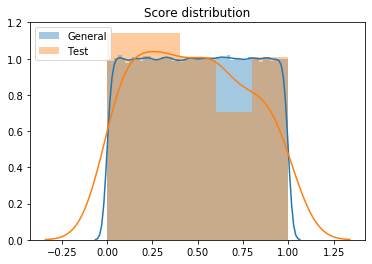

In [40]:
np.random.seed(42)

score = pd.DataFrame(data=np.random.rand(data_no_train.shape[0]))
score.index = data_no_train.index

print(f'Média score geral: {score.mean()}')
print(f'Média score dos testes: {score.loc[test.index].mean()}')

sns.distplot(score, label='General').set_title('Score distribution')
sns.distplot(score.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()

info.append([
    'Aleatório',
    score.mean()[0],
    score.loc[test.index].mean()[0],
    score.std()[0],
    score.min()[0],
    score.max()[0]
])

In [41]:
p2_info = pd.DataFrame(info, columns=info_columns)

p2_info

,tech,general_score,test_score,std,min_score,max_score
0,Média da similaridade e vetor usuário,0.071805,0.021720,0.071108,0.000121,0.467443
1,Média da similaridade com todas,0.649739,0.783422,0.231594,0.028618,0.888374
2,Maior similaridade entre todas,0.820980,0.989885,0.226393,0.106864,1.000000
3,Aleatório,0.500173,0.473634,0.288539,0.000002,0.999995


In [42]:
# Load clients of portifolio1

portfilio1 = pd.read_csv('../estaticos_portfolio3.csv', index_col=0)

info_columns = ['tech', 'general_score', 'test_score', 'std', 'min_score', 'max_score']
info = []

#### Usando vetor com média aritmética das features 

Para definir o perfil do portifólio e medir a similaridade entre esse vetor e todos

In [43]:
clients_p1_data = data.loc[portfilio1['id']]

train, test = train_test_split(clients_p1_data, test_size=0.2)

data_no_train = data.loc[set(data.index) - set(train.index)]

# Making the user profile
u = dict()
for col in train:
    u[col] = clients_p1_data[col].mean()

user = pd.DataFrame([u])

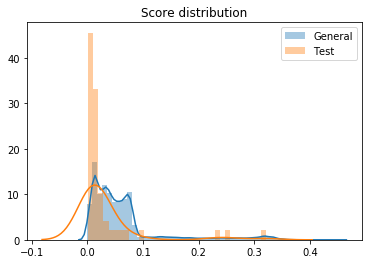

In [44]:
similarities = pd.DataFrame(data=cosine_similarity(data_no_train, user), columns=['score'])
similarities.index = data_no_train.index

sns.distplot(similarities, label='General').set_title('Score distribution')
sns.distplot(similarities.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()


In [45]:
print(f'Média score geral: {similarities.mean()}')
print(f'Média score dos testes: {similarities.loc[test.index].mean()}')

info.append([
    'Média da similaridade e vetor usuário',
    similarities.mean()[0],
    similarities.loc[test.index].mean()[0],
    similarities.std()[0],
    similarities.min()[0],
    similarities.max()[0]
])

Média score geral: score    0.062495
dtype: float64
Média score dos testes: score    0.031827
dtype: float64


#### Usando a similaridade entre todos e média

Usando média das similaridades entre uma empresa e as do treino para definir os scores

In [46]:
# Tira os dados que serão usados como treino, ou seja, empresas para comparar as demais que já estão no portifólio
data_no_train = data.loc[set(data.index) - set(train.index)]

# Calcula similaridade entre os dados e o treino
sim = cosine_similarity(data_no_train, train)

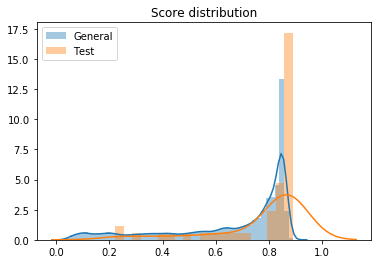

In [47]:
indexes = data_no_train.index
columns = train.index

similarities = pd.DataFrame(sim)
similarities.columns = columns
similarities.index = indexes
score = similarities.mean(axis=1)

sns.distplot(score, label='General').set_title('Score distribution')
sns.distplot(score.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()

In [48]:
# Score de cada empresa teste é média da similaridade dela com as de treino
# e o score da métrica é média do score dos testes
print(f'Média score geral: {score.mean()}')
print(f'Média score dos testes: {score.loc[test.index].mean()}')

info.append([
    'Média da similaridade com todas',
    score.mean(),
    score.loc[test.index].mean(),
    score.std(),
    score.min(),
    score.max()
])

Média score geral: 0.66246858943749
Média score dos testes: 0.7818526225489257


#### Usando a similaridade entre todos e maior

Usando a maior das similaridades entre uma empresa e as do treino para definir os scores

In [49]:
# Tira os dados que serão usados como treino, ou seja, empresas para comparar as demais que já estão no portifólio
data_no_train = data.loc[set(data.index) - set(train.index)]

# Calcula similaridade entre os dados e o treino
sim = cosine_similarity(data_no_train, train)

In [50]:
data.shape[0] == sum(sim.shape)

True

In [51]:
indexes = data_no_train.index
columns = train.index

similarities = pd.DataFrame(np.amax(sim, axis=1))
similarities.index = indexes

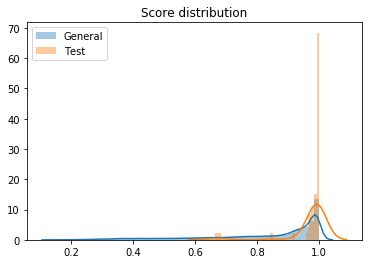

In [52]:
sns.distplot(similarities, label='General').set_title('Score distribution')
sns.distplot(similarities.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()

In [53]:
# Score de cada empresa teste é maior similaridade dela com as de treino
# e o score da métrica é média do score dos testes
print(f'Média score geral: {similarities.mean()}')
print(f'Média score dos testes: {similarities.loc[test.index].mean()}')


info.append([
    'Maior similaridade entre todas',
    similarities.mean()[0],
    similarities.loc[test.index].mean()[0],
    similarities.std()[0],
    similarities.min()[0],
    similarities.max()[0]
])

Média score geral: 0    0.835643
dtype: float64
Média score dos testes: 0    0.974435
dtype: float64


#### Recomendações aleatórias

Adicionar um valor aleatório entre 0 e 1 como score para cada empresa

Média score geral: 0    0.500165
dtype: float64
Média score dos testes: 0    0.450244
dtype: float64


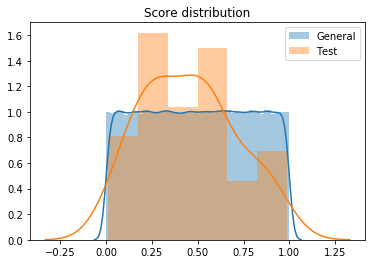

In [54]:
np.random.seed(42)

score = pd.DataFrame(data=np.random.rand(data_no_train.shape[0]))
score.index = data_no_train.index

print(f'Média score geral: {score.mean()}')
print(f'Média score dos testes: {score.loc[test.index].mean()}')

sns.distplot(score, label='General').set_title('Score distribution')
sns.distplot(score.loc[test.index], label='Test')
plt.legend(labels=['General', 'Test'])
plt.show()

info.append([
    'Aleatório',
    score.mean()[0],
    score.loc[test.index].mean()[0],
    score.std()[0],
    score.min()[0],
    score.max()[0]
])

In [55]:
p3_info = pd.DataFrame(info, columns=info_columns)

p3_info

,tech,general_score,test_score,std,min_score,max_score
0,Média da similaridade e vetor usuário,0.062495,0.031827,0.069348,0.000158,0.449621
1,Média da similaridade com todas,0.662469,0.781853,0.233564,0.034356,0.891394
2,Maior similaridade entre todas,0.835643,0.974435,0.189448,0.147481,1.000000
3,Aleatório,0.500165,0.450244,0.288538,0.000002,0.999995


In [56]:
p2_info

,tech,general_score,test_score,std,min_score,max_score
0,Média da similaridade e vetor usuário,0.071805,0.021720,0.071108,0.000121,0.467443
1,Média da similaridade com todas,0.649739,0.783422,0.231594,0.028618,0.888374
2,Maior similaridade entre todas,0.820980,0.989885,0.226393,0.106864,1.000000
3,Aleatório,0.500173,0.473634,0.288539,0.000002,0.999995


In [57]:
p1_info

,tech,general_score,test_score,std,min_score,max_score
0,Média da similaridade e vetor usuário,0.046660,0.049081,0.067829,3.047972e-07,0.377314
1,Média da similaridade com todas,0.671327,0.728386,0.172563,9.812395e-03,0.828532
2,Maior similaridade entre todas,0.920455,0.981294,0.108975,2.995365e-01,1.000000
3,Aleatório,0.500175,0.477776,0.288539,2.227296e-06,0.999995


In [59]:
# from scipy.spatial.distance import mahalanobis

# def mahalanobis_df(u, v, Vi):
#     '''
#         @param u: input DataFrame
#         @param v: input DataFrame
#         @param Vi: inverse of covariance matrix of features
        
#         @return matrix of distances between u and v, with cols = u.index and index = v.index
#     '''
#     out = pd.DataFrame()
#     for u_row in u.index:
#         data = []
#         for v_row in v.index:
#             data.append(mahalanobis(u.loc[u_row].values, v.loc[v_row].values, Vi))
            
#         out[u_row] = data
    
#     out.index = v.index
#     return out

# mahalanobis_df(data.iloc[0:300], data.iloc[300:600], covariance_matrix_pinverse)